In [1]:
from pyspark import SparkContext

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
from pyspark import SparkContext
import pandas as pd

# For data manipulations using SQL format and functions
from pandasql import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.sql.functions import count, countDistinct, rank, dense_rank
from pyspark.sql.window import Window

#Importing required libraries for Visualizations and Statistics 
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics

In [4]:
spark = SparkSession\
        .builder\
        .appName("CovidData")\
        .getOrCreate()

In [5]:
covid_df = spark.read.csv('COVID-19_Nursing_Home_Dataset_latest.csv', header = 'True',inferSchema='True')

#printing the number of rows and columns of the dataset
print((covid_df.count(), len(covid_df.columns)))
print('\n')
print(covid_df.show(5))

(169150, 59)


+-----------+-----------------------+--------------------+--------------------+-------------+--------------+-----------------+--------------+------------------------------+------------------------------------+-----------------------------------+-----------------------------------+----------------------------------+-----------------------------------+----------------------------------+---------------------------+--------------------------+--------------------------------+-------------------------------+------------------+-----------------------------+--------------------------------------+------------------------------------+------------------------------+------------------------+-------------------------------+------------------------------+-------------------------------+------------------------------+----------------------------+---------------------------+-------------------------+--------------------------+-----------------+-----------------------+-------------------

In [6]:
covid_df.printSchema()

root
 |-- Week Ending: string (nullable = true)
 |-- Federal Provider Number: string (nullable = true)
 |-- Provider Name: string (nullable = true)
 |-- Provider Address: string (nullable = true)
 |-- Provider City: string (nullable = true)
 |-- Provider State: string (nullable = true)
 |-- Provider Zip Code: integer (nullable = true)
 |-- Submitted Data: string (nullable = true)
 |-- Passed Quality Assurance Check: string (nullable = true)
 |-- Residents Weekly Admissions COVID-19: integer (nullable = true)
 |-- Residents Total Admissions COVID-19: integer (nullable = true)
 |-- Residents Weekly Confirmed COVID-19: integer (nullable = true)
 |-- Residents Total Confirmed COVID-19: integer (nullable = true)
 |-- Residents Weekly Suspected COVID-19: integer (nullable = true)
 |-- Residents Total Suspected COVID-19: integer (nullable = true)
 |-- Residents Weekly All Deaths: integer (nullable = true)
 |-- Residents Total All Deaths: integer (nullable = true)
 |-- Residents Weekly COVID-1

In [7]:
covid_df = covid_df.dropDuplicates()

print((covid_df.count(), len(covid_df.columns)))

(169150, 59)


In [8]:
# This function use to print feature with null values and null count 
def null_value_count(df, length):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    pct = nullRows*100/length
    if(nullRows > 0):
      temp = k,nullRows, pct
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [9]:
null_columns_count_list = null_value_count(covid_df,covid_df.count())

In [10]:
spark.createDataFrame(null_columns_count_list, ['Column_With_Null_Value', 'Null_Values_Count']).show(51)

+----------------------+-----------------+------------------+
|Column_With_Null_Value|Null_Values_Count|                _3|
+----------------------+-----------------+------------------+
|  Passed Quality As...|             3332|1.9698492462311559|
|  Residents Weekly ...|             4059|2.3996452852497785|
|  Residents Total A...|             4059|2.3996452852497785|
|  Residents Weekly ...|             4059|2.3996452852497785|
|  Residents Total C...|             4059|2.3996452852497785|
|  Residents Weekly ...|             4059|2.3996452852497785|
|  Residents Total S...|             4059|2.3996452852497785|
|  Residents Weekly ...|             4059|2.3996452852497785|
|  Residents Total A...|             4059|2.3996452852497785|
|  Residents Weekly ...|             4059|2.3996452852497785|
|  Residents Total C...|             4059|2.3996452852497785|
|    Number of All Beds|             5482| 3.240910434525569|
|  Total Number of O...|             4383|2.5911912503694947|
|  Resid

In [11]:
covid_df = covid_df.drop("Number of Ventilators in Facility","Number of Ventilators in Use for COVID-19","Any Current Supply of Ventilator Supplies","One-Week Supply of Ventilator Supplies")


In [12]:
covid_df = covid_df.dropna(subset = ("Residents Weekly Admissions COVID-19"))

In [13]:
covid_df = covid_df.dropna(subset = ("Residents Weekly Admissions COVID-19","One-Week Supply of Hand Sanitizer","Any Current Supply of Gloves"))

In [14]:
null_columns_count_list = null_value_count(covid_df,covid_df.count())
spark.createDataFrame(null_columns_count_list, ['Column_With_Null_Value', 'Null_Values_Count']).show(51)

+----------------------+-----------------+--------------------+
|Column_With_Null_Value|Null_Values_Count|                  _3|
+----------------------+-----------------+--------------------+
|    Number of All Beds|             1182|  0.7245399600338364|
|  Total Number of O...|               87|0.053329083352744305|
|  Resident Access t...|               20|0.012259559391435472|
|  Laboratory Type I...|               20|0.012259559391435472|
|  Laboratory Type I...|               20|0.012259559391435472|
|  Laboratory Type I...|               20|0.012259559391435472|
|  Shortage of Nursi...|               44|0.026971030661158038|
|  Shortage of Clini...|               47|0.028809964569873357|
|     Shortage of Aides|               43|0.026358052691586264|
|  Shortage of Other...|               50| 0.03064889847858868|
|  One-Week Supply o...|                1|6.129779695717736E-4|
|  Any Current Suppl...|                1|6.129779695717736E-4|
|  One-Week Supply o...|                

In [15]:
print((covid_df.count(), len(covid_df.columns)))

(163138, 55)


In [16]:
covid_df.na.fill(0).show()

+-----------+-----------------------+--------------------+--------------------+----------------+--------------+-----------------+--------------+------------------------------+------------------------------------+-----------------------------------+-----------------------------------+----------------------------------+-----------------------------------+----------------------------------+---------------------------+--------------------------+--------------------------------+-------------------------------+------------------+-----------------------------+--------------------------------------+------------------------------------+------------------------------+------------------------+-------------------------------+------------------------------+-------------------------------+------------------------------+----------------------------+---------------------------+-------------------------+--------------------------+-----------------+-----------------------+-------------------------------

In [17]:
# This function use to print feature with null values and null count 
def Summary(df):
  for k in df.columns:
    if(df[[k]].dtypes == [(k,'int')] or df[[k]].dtypes == [(k,'double')]):
        print(df[[k]].describe().show())

In [18]:
Summary(covid_df)

+-------+------------------+
|summary| Provider Zip Code|
+-------+------------------+
|  count|            163138|
|   mean| 50317.67057337959|
| stddev|26889.652680080057|
|    min|               660|
|    max|             99929|
+-------+------------------+

None
+-------+------------------------------------+
|summary|Residents Weekly Admissions COVID-19|
+-------+------------------------------------+
|  count|                              163138|
|   mean|                 0.44800720862092214|
| stddev|                   2.574189577897514|
|    min|                                   0|
|    max|                                 224|
+-------+------------------------------------+

None
+-------+-----------------------------------+
|summary|Residents Total Admissions COVID-19|
+-------+-----------------------------------+
|  count|                             163138|
|   mean|                  3.433160882197894|
| stddev|                 10.419200951640619|
|    min|                   

+-------+---------------------------------------------------------------------------+
|summary|Total Residents COVID-19 Deaths as a Percentage of Confirmed COVID-19 Cases|
+-------+---------------------------------------------------------------------------+
|  count|                                                                      64750|
|   mean|                                                         37.171213899613925|
| stddev|                                                         144.92859768764342|
|    min|                                                                        0.0|
|    max|                                                                     8600.0|
+-------+---------------------------------------------------------------------------+

None


In [19]:
Provider_Name_Cnt = covid_df.agg(countDistinct("Provider Name"))

In [20]:
Provider_Name_Cnt.show()

+--------------------+
|count(Provider Name)|
+--------------------+
|               14854|
+--------------------+



In [21]:

week_wise_sum_cases= covid_df.groupBy("Week Ending").sum("Total Resident Confirmed COVID-19 Cases Per 1,000 Residents").sort(col("sum(Total Resident Confirmed COVID-19 Cases Per 1,000 Residents)").desc())


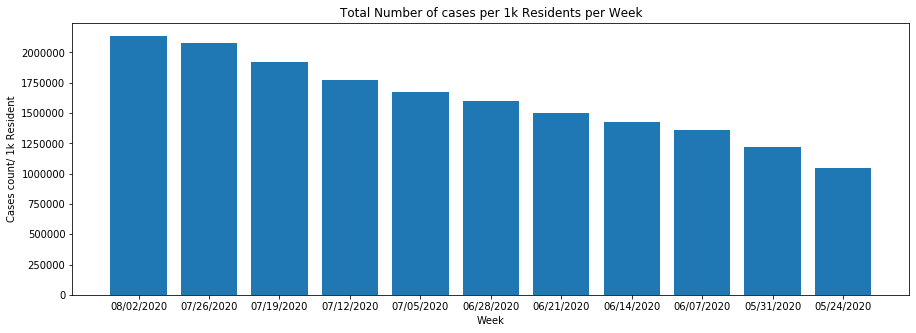

None

In [22]:
week_x=week_wise_sum_cases.toPandas()['Week Ending'].values.tolist()
week_y=week_wise_sum_cases.toPandas()['sum(Total Resident Confirmed COVID-19 Cases Per 1,000 Residents)'].values.tolist()

plt.figure(figsize=(15,5))
plt.bar(week_x,week_y)
plt.title('Total Number of cases per 1k Residents per Week')
plt.xlabel('Week')
plt.ylabel('Cases count/ 1k Resident')
display(plt.show())

In [23]:

week_wise_sum_deaths = covid_df.groupBy("Week Ending").sum("Total Resident COVID-19 Deaths Per 1,000 Residents").sort(col("sum(Total Resident COVID-19 Deaths Per 1,000 Residents)").desc())


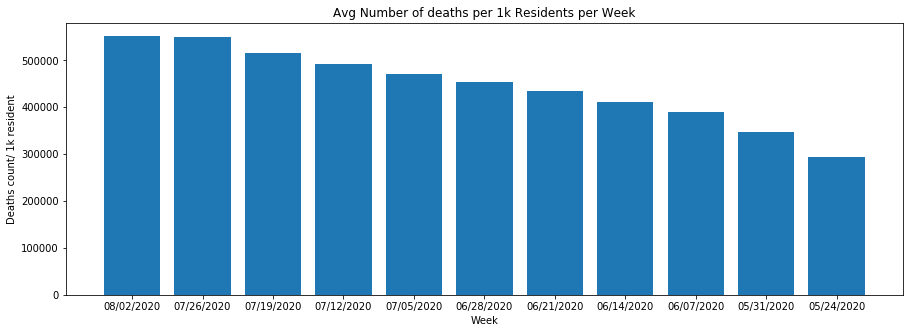

None

In [24]:
week_x=week_wise_sum_deaths.toPandas()['Week Ending'].values.tolist()
week_y=week_wise_sum_deaths.toPandas()['sum(Total Resident COVID-19 Deaths Per 1,000 Residents)'].values.tolist()

plt.figure(figsize=(15,5))
plt.bar(week_x,week_y)
plt.title('Avg Number of deaths per 1k Residents per Week')
plt.xlabel('Week')
plt.ylabel('Deaths count/ 1k resident')
display(plt.show())

In [25]:
## covid_df = covid_df.withColumnRenamed("Week Ending", "Week_Ending")

sqlContext.registerDataFrameAsTable(covid_df, "myTable")

from pyspark.sql.types import DateType
covid_df = covid_df.withColumn("Week_Ending",covid_df['Week Ending'].cast(DateType()))

covid_df[["Week_Ending"]].dtypes

[('Week_Ending', 'date')]

In [26]:
covid_df[['Week_Ending']].show(5)

+-----------+
|Week_Ending|
+-----------+
|       null|
|       null|
|       null|
|       null|
|       null|
+-----------+
only showing top 5 rows



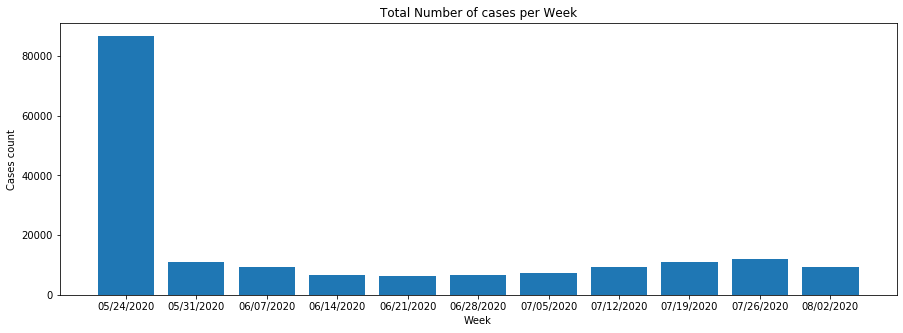

None

In [27]:
week_wise_sum_cases= covid_df.groupBy("Week Ending",'Week_Ending').sum("Residents Weekly Confirmed COVID-19").sort("Week Ending")

week_x=week_wise_sum_cases.toPandas()['Week Ending'].values.tolist()
week_y=week_wise_sum_cases.toPandas()['sum(Residents Weekly Confirmed COVID-19)'].values.tolist()

plt.figure(figsize=(15,5))
plt.bar(week_x,week_y)
plt.title('Total Number of cases per Week')
plt.xlabel('Week')
plt.ylabel('Cases count')
display(plt.show())

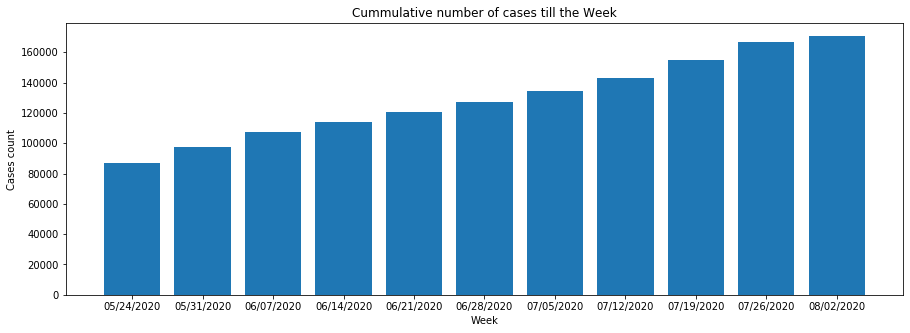

None

In [28]:
week_wise_sum_cases= covid_df.groupBy("Week Ending",'Week_Ending').sum("Residents Total Confirmed COVID-19").sort("Week Ending")

week_x=week_wise_sum_cases.toPandas()['Week Ending'].values.tolist()
week_y=week_wise_sum_cases.toPandas()['sum(Residents Total Confirmed COVID-19)'].values.tolist()

plt.figure(figsize=(15,5))
plt.bar(week_x,week_y)
plt.title('Cummulative number of cases till the Week')
plt.xlabel('Week')
plt.ylabel('Cases count')
display(plt.show())

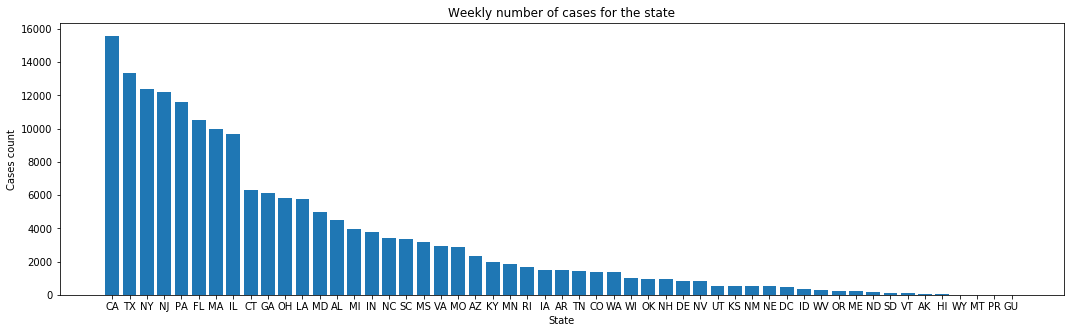

None

In [29]:
state_wise_sum_cases= covid_df.groupBy("Provider State").sum("Residents Weekly Confirmed COVID-19").sort(col("sum(Residents Weekly Confirmed COVID-19)").desc())

state_x=state_wise_sum_cases.toPandas()['Provider State'].values.tolist()
state_y=state_wise_sum_cases.toPandas()['sum(Residents Weekly Confirmed COVID-19)'].values.tolist()

plt.figure(figsize=(18,5))
plt.bar(state_x,state_y)
plt.title('Weekly number of cases for the state')
plt.xlabel('State')
plt.ylabel('Cases count')
display(plt.show())

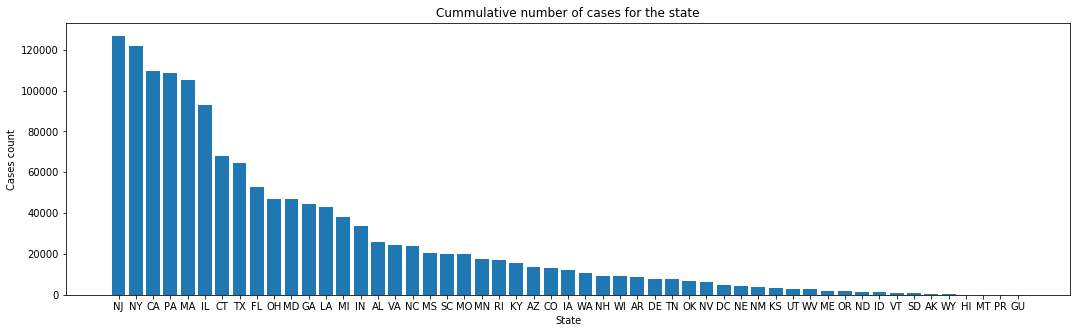

None

In [30]:
state_wise_sum_cases= covid_df.groupBy("Provider State").sum("Residents Total Confirmed COVID-19").sort(col("sum(Residents Total Confirmed COVID-19)").desc())

state_x=state_wise_sum_cases.toPandas()['Provider State'].values.tolist()
state_y=state_wise_sum_cases.toPandas()['sum(Residents Total Confirmed COVID-19)'].values.tolist()

plt.figure(figsize=(18,5))
plt.bar(state_x,state_y)
plt.title('Cummulative number of cases for the state')
plt.xlabel('State')
plt.ylabel('Cases count')
display(plt.show())

In [31]:
State = input("State")
State

StateCA


'CA'

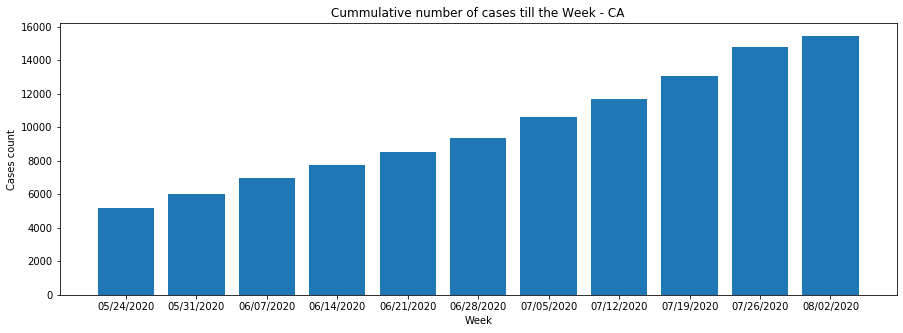

None

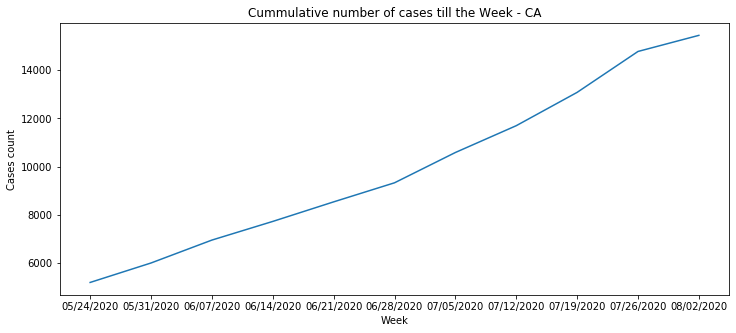

None

In [32]:
week_wise_sum_cases= covid_df.filter(col("Provider State") == State).groupBy("Week Ending",'Week_Ending').sum("Residents Total Confirmed COVID-19").sort(col("Week Ending"))

week_x=week_wise_sum_cases.toPandas()['Week Ending'].values.tolist()
week_y=week_wise_sum_cases.toPandas()['sum(Residents Total Confirmed COVID-19)'].values.tolist()

plt.figure(figsize=(15,5))
plt.bar(week_x,week_y)
plt.title('Cummulative number of cases till the Week - '+ State)
plt.xlabel('Week')
plt.ylabel('Cases count')
display(plt.show())

plt.figure(figsize=(12,5))
plt.plot(week_x,week_y)
plt.title('Cummulative number of cases till the Week - '+ State)
plt.xlabel('Week')
plt.ylabel('Cases count')
display(plt.show())

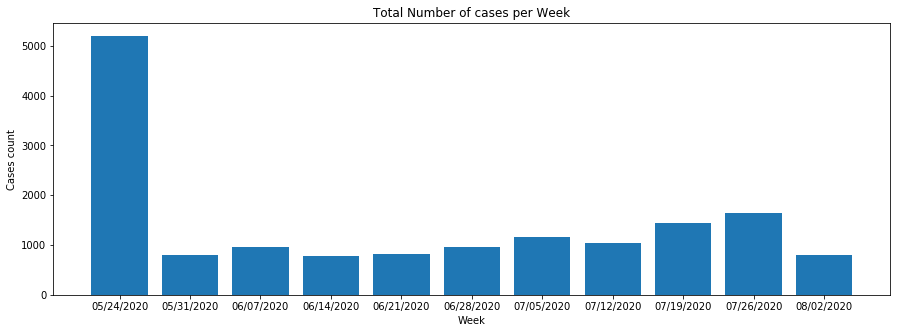

None

In [33]:
week_wise_sum_cases= covid_df.filter(col("Provider State") == State).groupBy("Week Ending",'Week_Ending').sum("Residents Weekly Confirmed COVID-19").sort("Week Ending")

week_x=week_wise_sum_cases.toPandas()['Week Ending'].values.tolist()
week_y=week_wise_sum_cases.toPandas()['sum(Residents Weekly Confirmed COVID-19)'].values.tolist()

plt.figure(figsize=(15,5))
plt.bar(week_x,week_y)
plt.title('Total Number of cases per Week')
plt.xlabel('Week')
plt.ylabel('Cases count')
display(plt.show())

In [34]:
Weeks = input("Week in format YYYY-MM-DD ")
Weeks

Week in format YYYY-MM-DD 2020-07-26


'2020-07-26'

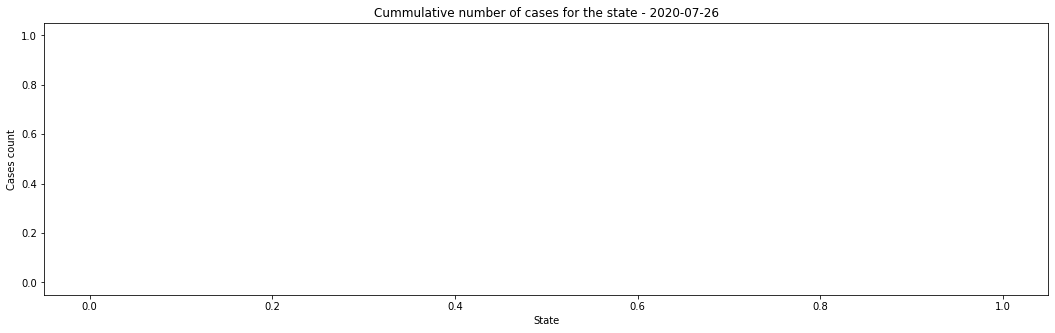

None

In [35]:
state_wise_sum_cases= covid_df.filter(col('Week Ending') == Weeks).groupBy("Provider State").sum("Residents Total Confirmed COVID-19").sort(col("sum(Residents Total Confirmed COVID-19)").desc())

state_x=state_wise_sum_cases.toPandas()['Provider State'].values.tolist()
state_y=state_wise_sum_cases.toPandas()['sum(Residents Total Confirmed COVID-19)'].values.tolist()

plt.figure(figsize=(18,5))
plt.bar(state_x,state_y)
plt.title('Cummulative number of cases for the state - '+Weeks)
plt.xlabel('State')
plt.ylabel('Cases count')
display(plt.show())

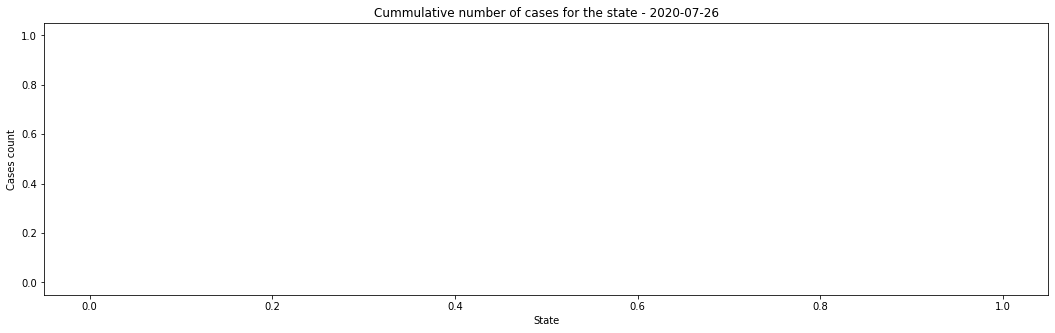

None

In [36]:
state_wise_sum_cases= covid_df.filter(col('Week Ending') == Weeks).groupBy("Provider State").sum("Residents Weekly Confirmed COVID-19").sort(col("sum(Residents Weekly Confirmed COVID-19)").desc())

state_x=state_wise_sum_cases.toPandas()['Provider State'].values.tolist()
state_y=state_wise_sum_cases.toPandas()['sum(Residents Weekly Confirmed COVID-19)'].values.tolist()

plt.figure(figsize=(18,5))
plt.bar(state_x,state_y)
plt.title('Cummulative number of cases for the state - '+Weeks)
plt.xlabel('State')
plt.ylabel('Cases count')
display(plt.show())

In [37]:
from pyspark.mllib.stat import Statistics
import pandas as pd

# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

In [38]:
covid_df.stat.corr("Residents Weekly Confirmed COVID-19","Residents Total Confirmed COVID-19")

0.3240685012415185

In [39]:
covid_df.stat.corr("Residents Weekly Confirmed COVID-19","Residents Weekly COVID-19 Deaths")

0.669153931532725

In [40]:
covid_df.stat.corr("Staff Weekly Confirmed COVID-19","Residents Weekly COVID-19 Deaths")

0.593176214963272

In [41]:
covid_df.write.csv('COVID-19_GROUP_FINAL_DATA_1.csv')

In [42]:
covid_df.toPandas().to_csv('COVID-19_GROUP_FINAL_DATA_2.csv')